# Charactor-level RNN for wiki

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math
import random
import torch
import torch.nn as nn

# # Plus EOS marker
# keywords_dict = {}
# keywords_dict['all_letters'] = string.ascii_letters + " .,;'-"
# keywords_dict['n_letters'] = len(keywords_dict['all_letters']) + 1

# def findFiles(path): return glob.glob(path)

# # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s, keywords_dict):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in keywords_dict['all_letters']
#     )

# # Read a file and split into lines
# def readLines(filename, keywords_dict):
#     lines = open(filename, encoding='utf-8').read().strip().split('\n')
#     return [unicodeToAscii(line, keywords_dict) for line in lines]

# # Build the category_lines dictionary, a list of lines per category
# name_list = []
# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     name_list.extend(readLines(filename, keywords_dict))
    
# keywords_dict['name_vector'] = name_list

In [ ]:
# parameter



In [2]:
data = open(r'data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = ''.join(data.split(', &c'))
data = ''.join(data.split(', &C'))
data = ''.join(data.split(',\' &c'))
data = ''.join(data.split(' &c'))
data = ''.join(data.split('&c'))
data = ''.join(data.split('['))
data = ''.join(data.split(']'))
data = data[:1000000]
# data= data
chars = sorted(list(set(data)))
# 
data_size, vocab_size = len(data), len(chars)
char_to_ix={}
for idex,i in enumerate(chars):
    char_to_ix[i]=idex
ix_to_char={}
for idex,i in enumerate(chars):
    ix_to_char[idex]=i
print('data has %d characters, %d unique.' % (data_size, vocab_size))

keywords_dict={}
# keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 10
keywords_dict['learning_rate'] = 0.1
keywords_dict['data_size'] = len(data)

keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
print(keywords_dict)

data has 1000000 characters, 63 unique.
{'seq_length': 10, 'all_letters': "\n !',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", 'learning_rate': 0.1, 'n_letters': 63, 'data_size': 1000000}


In [4]:
print(ix_to_char)
print(char_to_ix)

{0: '\n', 1: ' ', 2: '!', 3: "'", 4: ',', 5: '-', 6: '.', 7: '3', 8: ':', 9: ';', 10: '?', 11: 'A', 12: 'B', 13: 'C', 14: 'D', 15: 'E', 16: 'F', 17: 'G', 18: 'H', 19: 'I', 20: 'J', 21: 'K', 22: 'L', 23: 'M', 24: 'N', 25: 'O', 26: 'P', 27: 'Q', 28: 'R', 29: 'S', 30: 'T', 31: 'U', 32: 'V', 33: 'W', 34: 'X', 35: 'Y', 36: 'Z', 37: 'a', 38: 'b', 39: 'c', 40: 'd', 41: 'e', 42: 'f', 43: 'g', 44: 'h', 45: 'i', 46: 'j', 47: 'k', 48: 'l', 49: 'm', 50: 'n', 51: 'o', 52: 'p', 53: 'q', 54: 'r', 55: 's', 56: 't', 57: 'u', 58: 'v', 59: 'w', 60: 'x', 61: 'y', 62: 'z'}
{'N': 24, 'F': 16, 'u': 57, 'q': 53, 'R': 28, 'O': 25, 'g': 43, 'Y': 35, 'W': 33, 'V': 32, 'U': 31, 'b': 38, 'G': 17, 'l': 48, 'M': 23, '-': 5, 'B': 12, '!': 2, '?': 10, 'A': 11, 'K': 21, 'w': 59, 'y': 61, ':': 8, 'X': 34, 'D': 14, 'L': 22, 'r': 54, 'd': 40, 't': 56, 'a': 37, ';': 9, 'H': 18, 'P': 26, 'S': 29, 's': 55, 'j': 46, 'e': 41, 'f': 42, '\n': 0, 'z': 62, 'I': 19, ' ': 1, '.': 6, 'C': 13, 'v': 58, 'E': 15, 'n': 50, 'c': 39, 'J': 

In [6]:
p=0
seq_length=15
_a, _b = createTrainingExample(data[p:p+seq_length+1], keywords_dict)


In [7]:
data[p:p+seq_length+1]

'First Citizen:\nB'

In [8]:
_a,_b = createTrainingExample('First Citizen:\n', keywords_dict)

In [9]:
for i in _a:
    for jdex,j in enumerate(i[0]):
        if j==1:
            print(keywords_dict['all_letters'][jdex])
for i in _b:
    print(keywords_dict['all_letters'][i])
print(_b)

F
i
r
s
t
 
C
i
t
i
z
e
n
:
i
r
s
t
 
C
i
t
i
z
e
n
:


tensor([45, 54, 55, 56,  1, 13, 45, 56, 45, 62, 41, 50,  8,  0])


In [314]:
len(keywords_dict['all_letters'])

63

In [11]:
line='abc'
all_letters=keywords_dict['all_letters']
[all_letters.find(line[li]) for li in range(0, len(line))]

[37, 38, 39]

In [5]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
#     letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [12]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
# max_length = 100

# # Sample from a category and starting letter
# def sample(keywords_dict, start_letter='W'):
#     with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(max_length):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

#         return output_name
# sample(keywords_dict)

In [36]:
# with torch.no_grad():  # no need to track history in sampling
# #         category_tensor = categoryTensor(category)
#         _input = inputTensor(start_letter, keywords_dict)
#         hidden = rnn.initHidden()

#         output_name = start_letter

#         for i in range(25):
#             output, hidden = rnn(_input[0].to(device), hidden.to(device))
#             topv, topi = output.topk(1)
#             topi = topi[0][0]
#             letter = keywords_dict['all_letters'][topi]
#             output_name += letter
#             _input = inputTensor(letter, keywords_dict)

In [14]:
class RNN3(nn.Module):
    def __init__(self, input_size=keywords_dict['n_letters'], hidden_size=512, output_size=keywords_dict['n_letters'], n_layers=3):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
#         self.embed_dim = 20
#         self.word_to_vec = nn.Embedding(keywords_dict['n_letters'], self.embed_dim)
#         self.rnn = nn.RNN(self.embed_dim, hidden_size, n_layers, dropout=0.2)

        self.rnn = nn.RNN(input_size, hidden_size, n_layers, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, init):
        """
        input: a batch of one hot charactors [25, 1, 68]"""
        hidden = init
        return_ = []
        for i in range(input.size(0)):
            _input = input[i:i+1]
#             print(_input[0][0])
#             _input = self.word_to_vec(_input[0])
#             _input = _input.permute(1,0,2)
            output, hidden = self.rnn(_input, hidden)
            output = self.fc(output)
            output = self.softmax(output)
            return_.append(output)
        return return_, hidden
    
    def prediction(self, input, hidden):
        """        
        input: a batch of one hot charactors [1, 1, 68]"""
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self, batch_size):
        _test_a = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return torch.nn.init.normal_(_test_a, mean=0.0, std=0.001).to(device)

In [15]:
def init_prediction():
    _test_a = torch.zeros(3, 1, 120)
    return torch.tanh(torch.nn.init.normal_(_test_a, mean=0.0, std=0.001))

# check first layer



In [16]:
from  torch import autograd 

input_line_tensor, target_line_tensor = createTrainingExample(data[0:26], keywords_dict)
rnn_ = RNN3(keywords_dict['n_letters'], 120, keywords_dict['n_letters'], 3)
if torch.cuda.is_available:
    rnn_.to(device)
# _ = input_line_tensor.long()
_init = rnn_.initHidden(1)
output,_init = rnn_(input_line_tensor.to(device), _init)
# output = rnn_(input_line_tensor.cuda())
# # input_line_tensor[0:1]
# rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

In [17]:
output

[tensor([[[-4.2952, -4.1713, -4.2186, -4.0820, -4.1430, -4.1716, -4.0726,
           -4.2100, -4.1690, -4.1287, -4.0429, -4.1380, -4.1422, -4.0785,
           -4.1022, -4.2951, -4.0980, -4.1383, -4.2322, -4.1698, -4.0601,
           -4.2394, -4.1958, -4.0241, -4.1091, -4.2950, -4.1198, -4.2286,
           -4.0846, -4.1926, -4.1596, -4.0500, -4.2857, -4.0784, -4.2012,
           -4.1642, -4.1372, -4.0767, -4.1313, -4.2103, -4.1324, -4.0397,
           -4.2978, -4.0894, -4.3033, -4.0945, -4.1334, -4.1887, -4.0112,
           -4.0847, -4.1844, -4.1442, -4.0132, -4.2613, -4.0489, -4.0659,
           -4.2315, -4.1966, -4.1551, -4.1932, -4.0847, -4.1255, -3.9880]]],
        grad_fn=<LogSoftmaxBackward>),
 tensor([[[-4.2827, -4.1075, -4.2139, -4.0906, -4.1635, -4.1996, -4.0763,
           -4.2213, -4.0994, -4.1059, -4.0131, -4.1399, -4.1930, -4.1141,
           -4.0997, -4.3030, -4.0806, -4.1428, -4.2509, -4.1471, -4.0547,
           -4.3245, -4.1436, -4.0711, -4.0479, -4.3057, -4.1330, -4.23

In [19]:
output, _init = rnn_(input_line_tensor, _init)
print(_init)
# rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

tensor([[[ 0.0702, -0.0010,  0.0220, -0.0345, -0.1601,  0.0691, -0.0622,
          -0.0315, -0.0760,  0.0116,  0.0350, -0.0558,  0.0467,  0.1065,
           0.0790, -0.0142, -0.2275,  0.1863, -0.1201,  0.0409,  0.0624,
          -0.1301, -0.0042, -0.0617,  0.0124,  0.1480,  0.1334, -0.0932,
          -0.1765, -0.0791, -0.0711, -0.0075,  0.0751,  0.0665,  0.0941,
          -0.0706, -0.1210,  0.0405,  0.0492,  0.1174,  0.1609,  0.1003,
          -0.0332, -0.2022,  0.0700, -0.0369, -0.0526,  0.1316,  0.2009,
           0.1236, -0.1477, -0.0387,  0.0570, -0.1546,  0.0820,  0.1328,
          -0.1023, -0.1021, -0.0398, -0.1140, -0.1429,  0.0302,  0.0073,
          -0.1797,  0.1014,  0.0896,  0.0245,  0.1639, -0.0148, -0.0066,
          -0.0616, -0.0161,  0.0211, -0.0199,  0.0351,  0.0585, -0.1395,
          -0.0654, -0.0631,  0.0586,  0.0190, -0.0169,  0.2620, -0.0593,
          -0.1344,  0.0453,  0.1307, -0.0311,  0.0410,  0.0441, -0.1677,
           0.0117, -0.0418, -0.1085,  0.1545,  0.18

In [49]:
rnn =  RNN3(n_letters, 120, n_letters, 3).to(device)
rnn.initHidden(1)
print(list(rnn.parameters()))

[Parameter containing:
tensor([[ 0.0598, -0.0347,  0.0442,  ..., -0.0060, -0.0352,  0.0589],
        [ 0.0770,  0.0399,  0.0741,  ...,  0.0049,  0.0098,  0.0740],
        [ 0.0812, -0.0839, -0.0282,  ..., -0.0043, -0.0565, -0.0239],
        ...,
        [ 0.0068, -0.0369, -0.0603,  ...,  0.0598, -0.0161, -0.0376],
        [ 0.0722,  0.0805,  0.0100,  ...,  0.0079, -0.0911, -0.0511],
        [ 0.0747, -0.0518, -0.0790,  ...,  0.0451, -0.0612, -0.0354]],
       requires_grad=True), Parameter containing:
tensor([[ 0.0796, -0.0273,  0.0407,  ..., -0.0362,  0.0524, -0.0201],
        [-0.0474,  0.0895,  0.0867,  ...,  0.0429, -0.0613, -0.0641],
        [-0.0589, -0.0252,  0.0149,  ...,  0.0620, -0.0195,  0.0542],
        ...,
        [-0.0411, -0.0692, -0.0234,  ..., -0.0571,  0.0286, -0.0174],
        [-0.0355,  0.0083, -0.0844,  ..., -0.0867, -0.0409, -0.0454],
        [ 0.0597, -0.0443,  0.0606,  ..., -0.0428,  0.0419,  0.0350]],
       requires_grad=True), Parameter containing:
tensor([-

# Start trainning

In [41]:
true_training_rnn = None

In [58]:
from torch.nn.utils import clip_grad_norm_
def running(keywords_dict, training_rnn=None, epoch=1, return_lose=[]):
    n_letters = keywords_dict['n_letters']
    if training_rnn:
        print('loading pre model')
        rnn = training_rnn
    else:
        rnn =  RNN3(n_letters, 250, n_letters, 3)
    
    rnn.to(device)    
    seq_length = keywords_dict['seq_length']
    optimizer = torch.optim.RMSprop(rnn.parameters(), lr=0.001)
#     n_iters = 10
    print_every = 5000
    plot_every = 500
#     if not all_losses:
    all_losses=[0.1]* int(keywords_dict['data_size']*epoch/(seq_length*plot_every))
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    
    epo= 0
    batch_size=0
    while epo< epoch:
        _iter= p = 0
        loss = 0
        _init = rnn.initHidden(1)
        while p + seq_length +1 <= keywords_dict['data_size']:
            input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
            target_line_tensor.unsqueeze_(-1)

#             input_line_tensor = input_line_tensor
            output, _init = rnn(input_line_tensor.to(device), _init.detach())
#             loss=0
            for i in range(input_line_tensor.size(0)):
                l = criterion(output[i][0], target_line_tensor[i].to(device))
    #             print(l)
                if loss==0:
                    loss = l
                else:
                    loss += l
#             optimizer.zero_grad()
    #         loss.detach()
            if _iter %100==0:
                rnn.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += float(loss)
                loss=0
            p += seq_length # move data pointer
            _iter += 1 # iteration counter

            

            if _iter % plot_every == 0:
                gg = epo + _iter / (keywords_dict['data_size']/keywords_dict['seq_length']) * 100
                print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, gg, total_loss / plot_every))

            if _iter % plot_every == 0:
                
                all_losses[batch_size]=total_loss/plot_every
                batch_size +=1
                total_loss = 0

        epo += 1
        return_lose.extend(all_losses)
    return rnn, return_lose
n_letters = keywords_dict['n_letters']

# rnn = nn.RNN(input_size=n_letters, hidden_size=512, num_layers=3)
# rnn.to(device)

if true_training_rnn:
    true_training_rnn, all_losses = running( keywords_dict, training_rnn=true_training_rnn, return_lose=all_losses[:-1],epoch=2)
    
else:
    true_training_rnn, all_losses = running( keywords_dict, epoch=1)


loading pre model
0m 6s (500 0%) 25.6155
0m 13s (1000 0%) 20.1030
0m 20s (1500 0%) 19.3501
0m 28s (2000 1%) 19.2292
0m 36s (2500 1%) 18.3801
0m 44s (3000 1%) 17.5166
0m 51s (3500 1%) 17.7194
0m 59s (4000 2%) 17.9290
1m 8s (4500 2%) 17.6992
1m 15s (5000 2%) 17.4590
1m 22s (5500 2%) 17.0592
1m 30s (6000 3%) 16.1312
1m 38s (6500 3%) 16.0725
1m 45s (7000 3%) 16.2629
1m 54s (7500 3%) 16.7101
2m 2s (8000 4%) 16.4473
2m 10s (8500 4%) 16.3841
2m 18s (9000 4%) 16.3735
2m 27s (9500 4%) 15.8206
2m 36s (10000 5%) 16.7250
2m 46s (10500 5%) 16.3028
2m 55s (11000 5%) 16.2160
3m 4s (11500 5%) 16.2752
3m 15s (12000 6%) 16.3532
3m 24s (12500 6%) 16.2552
3m 33s (13000 6%) 16.7001
3m 42s (13500 6%) 16.0724
3m 51s (14000 7%) 16.9393
3m 59s (14500 7%) 16.9515
4m 7s (15000 7%) 16.9595
4m 15s (15500 7%) 16.4403
4m 24s (16000 8%) 18.1615
4m 33s (16500 8%) 17.3577
4m 42s (17000 8%) 15.7298
4m 50s (17500 8%) 16.6881
4m 58s (18000 9%) 17.0410
5m 7s (18500 9%) 16.2216
5m 15s (19000 9%) 16.1825
5m 23s (19500 9%) 17

In [94]:
torch.save(true_training_rnn, r'rnn_613_long_'+str(len(all_losses)))

/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RNN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Save model

In [ ]:
torch.save(the_model, PATH)

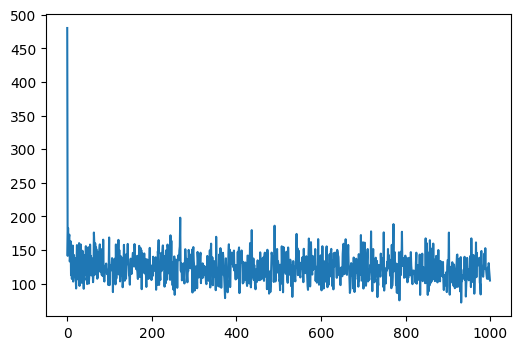

In [103]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
% matplotlib inline
plt.figure()
plt.plot(all_losses[:1000])

# Tempreture

In [ ]:
torch.load(r'C:\Users\hovea\Documents\GitHub\Sample_RNN\rnn_epoch1').fc.bias

# first apoche trainning

# Second training

In [91]:
def sample(preds, temperature=0.3):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = preds / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    out = np.random.choice(range(len(chars)), p=probas.ravel())
    return out

Parameter containing:
tensor([ 0.0368,  0.0601, -0.1698, -0.0039,  0.0134, -0.1460, -0.0965, -0.2545,
         0.0391, -0.1226, -0.0843, -0.0417,  0.0043,  0.0572, -0.1686, -0.1092,
        -0.0519, -0.1085, -0.0746, -0.1244, -0.1314, -0.1158, -0.1267, -0.0189,
        -0.2010, -0.0362,  0.0186, -0.1798,  0.0138, -0.0494, -0.0765, -0.0171,
        -0.1483,  0.0047, -0.1870, -0.1197, -0.1708,  0.0340, -0.0561, -0.0268,
        -0.0404,  0.0215,  0.0291, -0.0901,  0.0203,  0.0725, -0.2512, -0.1446,
         0.0494,  0.0221,  0.0354,  0.0043, -0.0133, -0.1334,  0.1141,  0.0559,
         0.0169, -0.0262, -0.0676,  0.0030, -0.2358,  0.0348, -0.1529],
       requires_grad=True)
KING LEAR:
Good so signior with a life,
And that is a wife, and hands, I will will that that in her father be and a fear in the word and heard this will be since and a chander to the riving and to the world have for a father say a pray and man me be a words and strangence to make to see to his best of a woone in a goo

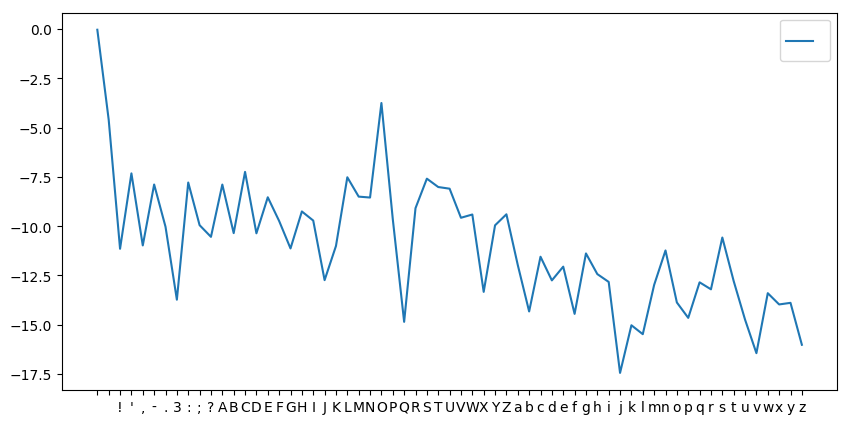

In [93]:
max_length = 2000
import numpy as np
# rnn=rnn_test
# rnn = torch.load('rnn_613_mac_fin_354000',map_location='cpu')
rnn= true_training_rnn
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))
_hidden_test = rnn.initHidden(1)
_hidden = _hidden_test
# for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

#         _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
#         _hidden = init_prediction()
        output_name = ''.join(["K","I","N","G"," ","L","E","A","R",":"])
        for i in ["K","I","N","G"," ","L","E","A","R",":"]:
#             print(i)
            _input = inputTensor(i, keywords_dict)
#             print(_input)
            _output, _hidden = rnn.prediction(_input, _hidden)
#             print("out",_output)
        plt.plot(list(keywords_dict['all_letters']),list(_output[0][0]), )
            
        topi= sample(_output[0][0])
        letter = keywords_dict['all_letters'][topi]
#         print("The start:", letter)
        output_name += letter
        _input = inputTensor(letter, keywords_dict)
        
        for i in range(max_length):
            output, _hidden = rnn.prediction(_input, _hidden)
#             if i==0:
                
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0])
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(["\n"]) 
# plt.xlim()
    

In [61]:
data[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [156]:
rnn_test = torch.load(r'./rnn_613_mac_fin_354000')

In [168]:
data[1:100]

'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [69]:
data = open(r'data/shakespeare_input.txt', 'r').read() # should be simple plain text file
data = ''.join(data.split(', &c'))
data = ''.join(data.split(', &C'))
data = ''.join(data.split(',\' &c'))
data = ''.join(data.split(' &c'))
data = ''.join(data.split('&c'))
data = ''.join(data.split('['))
data = ''.join(data.split(']'))
# data = data[:1000000]
sent_list = []
for i in data.split('\n\n'):
    sent_list.append(' '.join(i.split('\n')))
data_sent = sent_list
# data= data
chars = list(set(data))
# 
data_size, vocab_size = len(data), len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }
print('data has %d characters, %d unique.' % (data_size, vocab_size))

keywords_dict={}
# keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 10
keywords_dict['learning_rate'] = 0.1
keywords_dict['data_size'] = len(data)

keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)
print(keywords_dict)

data has 4573265 characters, 63 unique.
{'seq_length': 10, 'all_letters': "\n !',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz", 'learning_rate': 0.1, 'n_letters': 63, 'data_size': 4573265}


In [70]:
max_len = 0
# for i in data_sent:
#     if max_len < len(i):
#         max_len = len(i)
#         print(i)
# print(max_len)
sent_list = []
for i in range(len(data_sent)):
    if len(data_sent[i])>200:continue
    data_sent[i]+='\n'
    data_sent[i] += ' '*(199-len(data_sent[i]))
    
    sent_list.append(data_sent[i] )


In [80]:
sent_list[0]

"ANTONIO: Who's there?\n                                                                                                                                                                                 "

In [75]:
print(len(sent_list))

24934


In [99]:
#data_sent
data_sent=sent_list[:10000]
from torch.nn.utils import clip_grad_norm_
def running(keywords_dict, training_rnn=None, epoch=1, data_sent=[]):
    n_letters = keywords_dict['n_letters']
    if training_rnn:
        print('loading pre model')
        rnn = training_rnn
    else:
        rnn =  RNN3(n_letters, 120, n_letters, 3)
    
    rnn.to(device)    
    seq_length = keywords_dict['seq_length']
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
#     n_iters = 10
#     print_every = 5000
    plot_every = 20
    all_losses=[0.1]* epoch*len(data_sent)
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    
    epo= 0
    batch_size=0
    while epo< epoch:
        _iter= p = 0
        loss = 0
        random.shuffle(data_sent) 
        for sent in data_sent:
            input_line_tensor, target_line_tensor = createTrainingExample(sent, keywords_dict)
            target_line_tensor.unsqueeze_(-1)

#             input_line_tensor = input_line_tensor
            _init = rnn.initHidden(1)
            output, _init = rnn(input_line_tensor.to(device), _init)
#             loss=0
            for i in range(input_line_tensor.size(0)):
                l = criterion(output[i][0], target_line_tensor[i].to(device))
    #             print(l)
                if loss==0:
                    loss = l
                else:
                    loss += l
#             optimizer.zero_grad()
    #         loss.detach()
#             if _iter %10==0:
                
            rnn.zero_grad()

            loss.backward()
    #         _init = _
#                 clip_grad_norm_(rnn.parameters(), 0.5)
            optimizer.step()
            total_loss += float(loss)
            loss=0
            p += seq_length # move data pointer
            _iter += 1 # iteration counter

            

            if _iter % plot_every == 0:
                gg = (epo + _iter / len(data_sent)) * 100
                print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, gg, total_loss / plot_every))

            if _iter % plot_every == 0:
                
                all_losses[batch_size]=total_loss/plot_every
                batch_size +=1
                total_loss = 0

        epo += 1
        
    return rnn, all_losses
n_letters = keywords_dict['n_letters']

# rnn = nn.RNN(input_size=n_letters, hidden_size=512, num_layers=3)
# rnn.to(device)
true_training_rnn_sent=torch.load(r'rnn_613_short_10000')
if true_training_rnn_sent:
    true_training_rnn_sent, all_losses = running( keywords_dict, training_rnn=true_training_rnn_sent, epoch=2, data_sent=data_sent )
    
else:
    true_training_rnn_sent, all_losses = running( keywords_dict, epoch=1, data_sent=data_sent)


loading pre model
0m 6s (20 0%) 480.2263
0m 13s (40 0%) 141.3090
0m 21s (60 0%) 182.7652
0m 29s (80 0%) 149.1587
0m 38s (100 1%) 168.4349
0m 45s (120 1%) 172.8222
0m 52s (140 1%) 132.9326
0m 58s (160 1%) 139.2196
1m 5s (180 1%) 163.1054
1m 12s (200 2%) 112.4940
1m 19s (220 2%) 145.4942
1m 26s (240 2%) 106.9445
1m 32s (260 2%) 143.3321
1m 39s (280 2%) 156.6103
1m 46s (300 3%) 103.0576
1m 53s (320 3%) 111.6443
1m 59s (340 3%) 142.5776
2m 6s (360 3%) 117.9828
2m 13s (380 3%) 138.0998
2m 20s (400 4%) 130.0514
2m 27s (420 4%) 108.4284
2m 33s (440 4%) 92.7661
2m 40s (460 4%) 131.1073
2m 47s (480 4%) 157.3344
2m 53s (500 5%) 106.4570
3m 0s (520 5%) 132.8433
3m 7s (540 5%) 127.1640
3m 14s (560 5%) 113.3670
3m 20s (580 5%) 160.2249
3m 27s (600 6%) 96.6092
3m 34s (620 6%) 118.8221
3m 40s (640 6%) 131.9063
3m 47s (660 6%) 158.2302
3m 54s (680 6%) 125.5642
4m 0s (700 7%) 101.2712
4m 7s (720 7%) 125.0966
4m 14s (740 7%) 148.8640
4m 21s (760 7%) 121.3369
4m 27s (780 7%) 115.1564
4m 34s (800 8%) 92.3

In [ ]:
torch.save(true_training_rnn, r'rnn_613_short_'+str(len(all_losses)))

Parameter containing:
tensor([-0.2700,  0.1137, -0.2445, -0.0930, -0.0441, -0.2599, -0.2398, -0.5017,
        -0.0323, -0.2455, -0.2171,  0.1417,  0.0286,  0.0187, -0.2654,  0.0125,
        -0.1258, -0.1905, -0.0972, -0.0018, -0.1661, -0.2951,  0.0091,  0.0163,
        -0.2740, -0.0378,  0.0221, -0.3541,  0.1678, -0.0079, -0.0219,  0.0439,
        -0.1819, -0.0446, -0.3866, -0.2556, -0.3447,  0.0316, -0.1226, -0.0333,
        -0.0638,  0.0810, -0.0200, -0.1735, -0.0201,  0.0824, -0.3538, -0.2735,
         0.1631,  0.0025,  0.0350,  0.0664, -0.1027, -0.2546,  0.1635,  0.1265,
         0.0348, -0.0692, -0.1776, -0.0246, -0.4302, -0.0859, -0.2315],
       requires_grad=True)
ANO: And the good from the word, I will the word sir, the tonger to the death your proves to the for the done of the grace to the tontent to the soul to the godes to the prace to the tong the hand the rest you wonder with this word to the sever the sont to the man: I was the sent to the confering to see, I will the wo

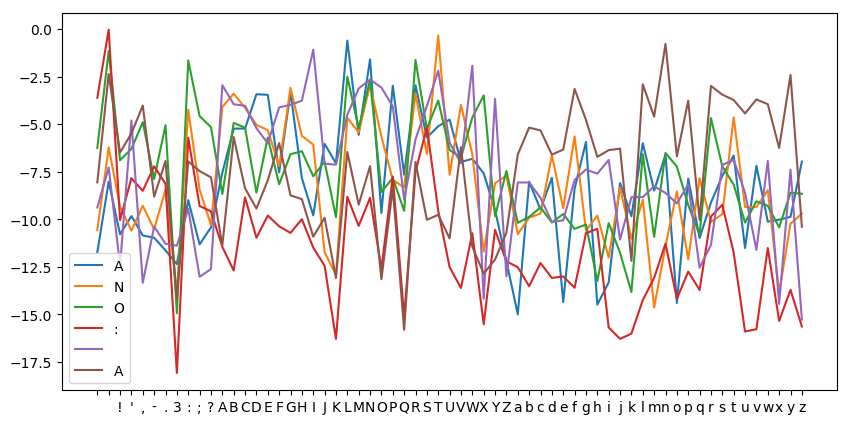

In [114]:
max_length = 2000
import numpy as np
rnn=true_training_rnn_sent
# rnn = torch.load('/Users/apple/PycharmProjects/RNN_CSE254/Sample_RNN/rnn_612_1240',map_location='cpu')
print(rnn.fc.bias)
# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
plt.figure(figsize=(10,5))
_hidden_test = rnn.initHidden(1)
_hidden = _hidden_test
# for start_letter in ['A', 'B','C', 'D', 'E', 'F']:
with torch.no_grad():  # no need to track history in sampling
    #         category_tensor = categoryTensor(category)

#         _input = inputTensor(start_letter, keywords_dict)
    #         _input.to(device)
#         _hidden = init_prediction()
        output_name = 'ANO: A'
        for i in 'ANO: A':
#             print(i)
            _input = inputTensor(i, keywords_dict)
#             print(_input)
            _output, _hidden = rnn.prediction(_input, _hidden)
#             print("out",_output)
            plt.plot(list(keywords_dict['all_letters']),list(_output[0][0]), )
            
        topi= sample(_output[0][0])
        letter = keywords_dict['all_letters'][topi]
#         print("The start:", letter)
        output_name += letter
        _input = inputTensor(letter, keywords_dict)
        
        for i in range(max_length):
            output, _hidden = rnn.prediction(_input, _hidden)
#             if i==0:
                
#                 plt.show()
#             topv, topi = output[0][0].topk(1)
            topi= sample(output[0][0], 0.3)
#             topi = topi[0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)
            _input.to(device)
        print(output_name)
plt.legend(["A","N","O",":", ' ',"A"]) 
# plt.xlim()
    

In [108]:
torch.save(true_training_rnn, r'rnn_613_short_'+str(len(all_losses)))

/Users/apple/anaconda3/lib/python3.5/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type RNN3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
